# MNIST example

This notebook provides a proof of concept for our framework, assuming this very simple instance of the framework:

- The data layer is composed by 10 classifiers, one per each digit of the MNIST dataset, i.e., one classifier that recognizes zeroes, one that recognizes ones, and so on.

- The Ontology alphabet contains one class per each digit (Zero, One, Two, ..., Nine), and the theory is empty

- The mapping maps each classifier to the class it recognizes

The proof of concept is structured as follows:

1. Train the 10 classifiers

2. Transform the query into a system of inequalities

3. Solve the system, and show a witness is the system is satisfiable

# **1. Build the Classifiers**

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset

import numpy as np
import matplotlib.pyplot as plt
import os

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

ModuleNotFoundError: No module named 'torch'

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.7.0+cu128
12.8


In [7]:
batch_size = 32

data_dir = './data'

train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

posTests = []
for i in range(10):
  indices = [j for j, (img, label) in enumerate(test_dataset) if label == i]
  ds = Subset(test_dataset, indices)
  posTests.append(DataLoader(dataset=ds, batch_size=batch_size, shuffle=False))

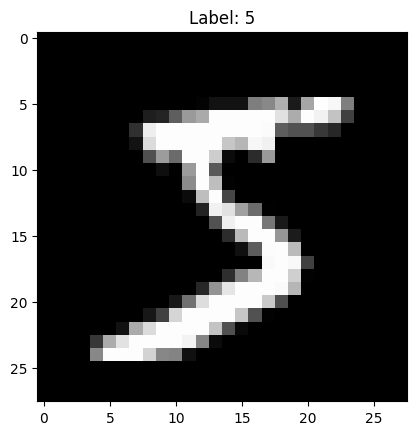

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [44]:
first_sample = train_dataset[0]
image, label = first_sample
image_np = image.numpy().squeeze()

#print image
plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

#print tensor
print(image.flatten())

In [9]:
class SimpleSLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return x

models = []
criterions = []
optimizers = []

pos_weight = torch.tensor([9.0]).to(device) #peso ai sample positivi per contrastare sbilanciamento dataset (istanze positive sono solo il 10% del dataset)

for i in range(10):
  models.append(SimpleSLP().to(device))
  criterions.append(nn.BCEWithLogitsLoss(pos_weight=pos_weight))
  optimizers.append(torch.optim.Adam(models[i].parameters()))
print(models)
print(criterions)
print(optimizers)

[SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
), SimpleSLP(
  (fc): Linear(in_features=784, out_features=1, bias=True)
)]
[BCEWithLogitsLoss(), BCEWithLogitsLoss(), BCEWithLogitsLoss(), BCEWithLogitsLoss(), BCEWithLogitsLoss(), BCEWithLogitsLoss(), BCEWithLogitsLoss(), BCEWithLogitsLoss(), BCEWithLogitsLoss(), BCEWithLogitsLoss()]
[Adam (
Parameter Group 0
    amsgrad: False
    betas: (0

In [10]:
def correct(output, target):
    predicted_digits = torch.heaviside(output, torch.tensor([1.0]).to(device)) #se output>=0 allora ritorna 1, altrimenti 0
    correct_ones = (predicted_digits == target).type(torch.float) #vettore con 1 dove la predizione era corretta, 0 dove era sbagliata
    return correct_ones.sum().item() #conta i corretti

In [11]:
def train(data_loader, model, criterion, optimizer, classNumber):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)
        '''
        for image, label in zip(data, target):
          print(image)
          image_np = image.numpy().squeeze()
          plt.imshow(image_np, cmap='gray')
          plt.title(f"Label: {label}")
          plt.show()
        '''
        # converte le label in 1 per il valore scelto e 0 per tutti gli altri valori
        #print(f"label originali: {target}")
        target = (target == classNumber).type(torch.float).reshape(-1, 1)
        #print("label convertite:", target.flatten())

        output = model(data)
        #print("prediction: ", output.flatten())
        loss = criterion(output, target)
        total_loss += loss

        total_correct += correct(output, target)
        #print("azzeccate: ", correct(output, target))
        #print("azzeccate: ", total_correct)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")


In [12]:
def test(test_loader, model, criterion, classNumber):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # Copy data and targets to GPU
            data = data.to(device)
            target = (target == classNumber).type(torch.float).reshape(-1, 1)
            target = target.to(device)
            # Do a forward pass
            output = model(data)

            # Calculate the loss
            loss = criterion(output, target)
            test_loss += loss.item()

            # Count number of correct digits
            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>7f}")

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, data_loader, classNumber, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            binary_labels = (labels == classNumber).int()
            outputs = model(images).view(-1)
            preds = (outputs >= 0).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(binary_labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["non-"+str(classNumber), str(classNumber)])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix for class {classNumber}")
    plt.show()


In [14]:
def disegna(arr):
  tens = torch.tensor(arr)
  img = np.array(tens, dtype=np.uint8).reshape((28, 28))
  img = np.array(img).reshape((28, 28))
  plt.imshow(img, cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.title(f"esempio positivo")
  plt.show()
  print(arr)

In [15]:
def is0(img_array):
    disegna(img_array)
    out = models[0](torch.FloatTensor(img_array).to(device))
    print(out)
    prediction = torch.heaviside(out, torch.tensor([1.0]).to(device))
    print("è uno 0?")
    if prediction==0:
        print("NO!")
    else:
        print("YES!")

In [38]:
def isValid(witness, q, x_vars):
    flag = True
    witness_values = [witness[x_var].as_long() for x_var in x_vars]
    disegna(witness_values)
    for model, i in zip(q, range(len(q))):
        out = model(torch.FloatTensor(witness_values).to(device))
        print("il classificatore", i, "dice:", out)
        prediction = torch.heaviside(out, torch.tensor([1.0]).to(device))
        if prediction==0:
            print("Non è istanza positiva del modello", i)
            flag = False
    if flag==True:
        print("Istanza positiva di tutti i modelli!")

## Classifier for Zeroes

In [3]:
%%time

epochs = 10
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, models[0], criterions[0], optimizers[0], 0)

Training epoch: 1


NameError: name 'train' is not defined

In [4]:
test(test_loader, models[0], criterions[0], 0)
test(posTests[0], models[0], criterions[0], 0)

NameError: name 'test' is not defined

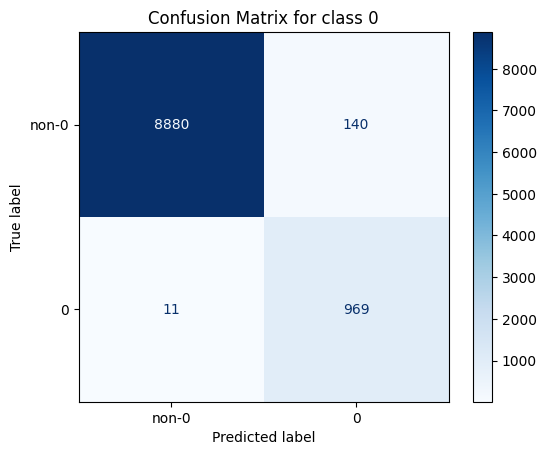

In [ ]:
plot_confusion_matrix(models[0], test_loader, 0)

## Classifiers for 1-9

----------------------Training classifier for 1----------------------------
Training epoch: 1
Average loss: 0.193880, accuracy: 96.79%
Training epoch: 2
Average loss: 0.110888, accuracy: 97.70%
Training epoch: 3
Average loss: 0.099621, accuracy: 97.95%
Training epoch: 4
Average loss: 0.094192, accuracy: 98.06%
Training epoch: 5
Average loss: 0.089378, accuracy: 98.14%
Training epoch: 6
Average loss: 0.087795, accuracy: 98.19%
Training epoch: 7
Average loss: 0.085186, accuracy: 98.24%
Training epoch: 8
Average loss: 0.083562, accuracy: 98.27%
Training epoch: 9
Average loss: 0.082600, accuracy: 98.29%
Training epoch: 10
Average loss: 0.081279, accuracy: 98.34%
Testset accuracy: 98.5%, average loss: 0.076703


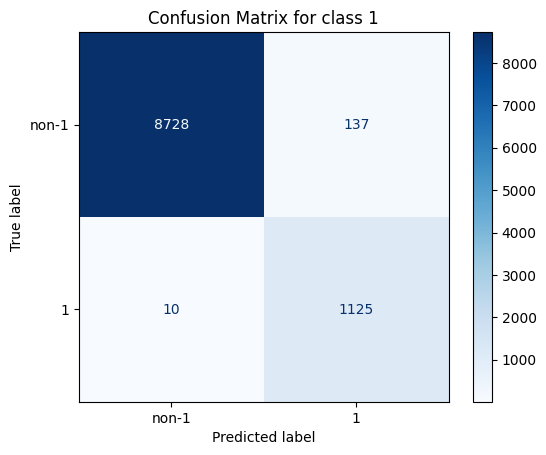

----------------------Training classifier for 2----------------------------
Training epoch: 1
Average loss: 0.383770, accuracy: 93.47%
Training epoch: 2
Average loss: 0.290757, accuracy: 95.54%
Training epoch: 3
Average loss: 0.276941, accuracy: 95.75%
Training epoch: 4
Average loss: 0.270165, accuracy: 95.95%
Training epoch: 5
Average loss: 0.264507, accuracy: 95.96%
Training epoch: 6
Average loss: 0.262298, accuracy: 96.08%
Training epoch: 7
Average loss: 0.260365, accuracy: 96.08%
Training epoch: 8
Average loss: 0.257564, accuracy: 96.10%
Training epoch: 9
Average loss: 0.256083, accuracy: 96.13%
Training epoch: 10
Average loss: 0.254224, accuracy: 96.13%
Testset accuracy: 97.5%, average loss: 0.315980


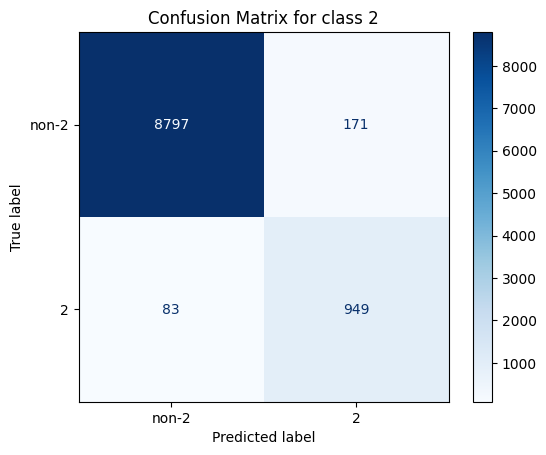

----------------------Training classifier for 3----------------------------
Training epoch: 1
Average loss: 0.429246, accuracy: 91.92%
Training epoch: 2
Average loss: 0.337998, accuracy: 93.59%
Training epoch: 3
Average loss: 0.325963, accuracy: 93.76%
Training epoch: 4
Average loss: 0.319374, accuracy: 93.90%
Training epoch: 5
Average loss: 0.313798, accuracy: 94.05%
Training epoch: 6
Average loss: 0.311379, accuracy: 94.09%
Training epoch: 7
Average loss: 0.308027, accuracy: 94.15%
Training epoch: 8
Average loss: 0.306784, accuracy: 94.12%
Training epoch: 9
Average loss: 0.303967, accuracy: 94.23%
Training epoch: 10
Average loss: 0.302249, accuracy: 94.29%
Testset accuracy: 94.6%, average loss: 0.275904


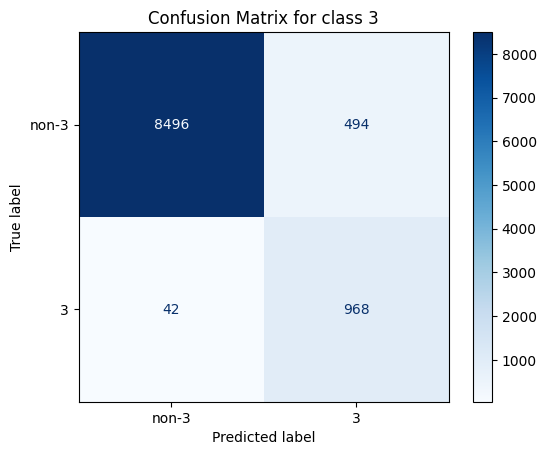

----------------------Training classifier for 4----------------------------
Training epoch: 1
Average loss: 0.307438, accuracy: 93.87%
Training epoch: 2
Average loss: 0.192592, accuracy: 96.23%
Training epoch: 3
Average loss: 0.177335, accuracy: 96.47%
Training epoch: 4
Average loss: 0.170924, accuracy: 96.66%
Training epoch: 5
Average loss: 0.167288, accuracy: 96.69%
Training epoch: 6
Average loss: 0.164044, accuracy: 96.77%
Training epoch: 7
Average loss: 0.161719, accuracy: 96.80%
Training epoch: 8
Average loss: 0.160185, accuracy: 96.85%
Training epoch: 9
Average loss: 0.158705, accuracy: 96.90%
Training epoch: 10
Average loss: 0.157481, accuracy: 96.92%
Testset accuracy: 96.6%, average loss: 0.159263


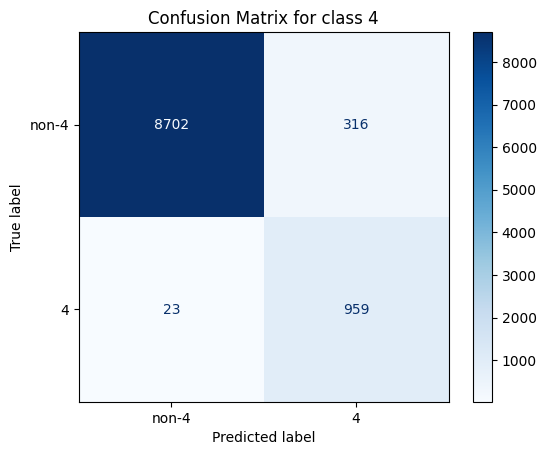

----------------------Training classifier for 5----------------------------
Training epoch: 1
Average loss: 0.492092, accuracy: 91.38%
Training epoch: 2
Average loss: 0.371273, accuracy: 92.88%
Training epoch: 3
Average loss: 0.350758, accuracy: 93.32%
Training epoch: 4
Average loss: 0.340794, accuracy: 93.49%
Training epoch: 5
Average loss: 0.334630, accuracy: 93.72%
Training epoch: 6
Average loss: 0.330602, accuracy: 93.72%
Training epoch: 7
Average loss: 0.326088, accuracy: 93.84%
Training epoch: 8
Average loss: 0.323588, accuracy: 93.87%
Training epoch: 9
Average loss: 0.321277, accuracy: 94.02%
Training epoch: 10
Average loss: 0.319518, accuracy: 94.02%
Testset accuracy: 92.8%, average loss: 0.320306


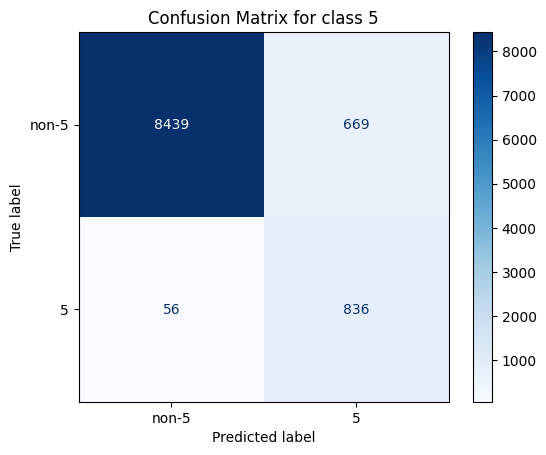

----------------------Training classifier for 6----------------------------
Training epoch: 1
Average loss: 0.243704, accuracy: 96.00%
Training epoch: 2
Average loss: 0.150688, accuracy: 96.99%
Training epoch: 3
Average loss: 0.139998, accuracy: 97.05%
Training epoch: 4
Average loss: 0.135187, accuracy: 97.18%
Training epoch: 5
Average loss: 0.131374, accuracy: 97.23%
Training epoch: 6
Average loss: 0.129631, accuracy: 97.30%
Training epoch: 7
Average loss: 0.126781, accuracy: 97.36%
Training epoch: 8
Average loss: 0.125010, accuracy: 97.36%
Training epoch: 9
Average loss: 0.123449, accuracy: 97.39%
Training epoch: 10
Average loss: 0.123171, accuracy: 97.42%
Testset accuracy: 97.8%, average loss: 0.127982


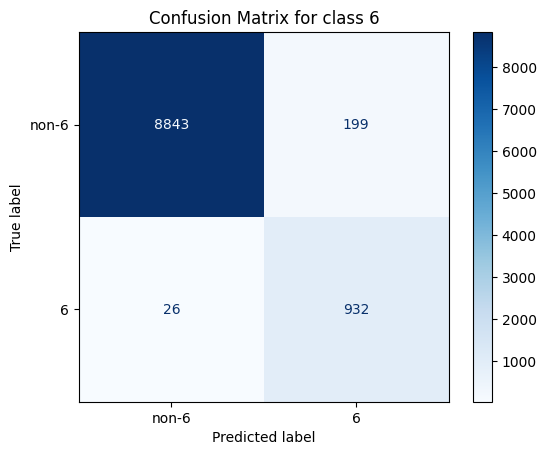

----------------------Training classifier for 7----------------------------
Training epoch: 1
Average loss: 0.275941, accuracy: 95.46%
Training epoch: 2
Average loss: 0.185942, accuracy: 96.65%
Training epoch: 3
Average loss: 0.174941, accuracy: 96.81%
Training epoch: 4
Average loss: 0.168445, accuracy: 96.90%
Training epoch: 5
Average loss: 0.165594, accuracy: 96.91%
Training epoch: 6
Average loss: 0.162453, accuracy: 96.99%
Training epoch: 7
Average loss: 0.160848, accuracy: 96.99%
Training epoch: 8
Average loss: 0.158537, accuracy: 97.00%
Training epoch: 9
Average loss: 0.157839, accuracy: 97.04%
Training epoch: 10
Average loss: 0.156237, accuracy: 97.08%
Testset accuracy: 97.2%, average loss: 0.213246


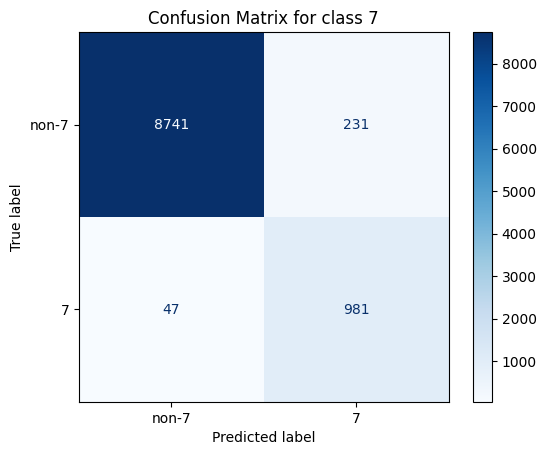

----------------------Training classifier for 8----------------------------
Training epoch: 1
Average loss: 0.596051, accuracy: 84.18%
Training epoch: 2
Average loss: 0.483023, accuracy: 88.37%
Training epoch: 3
Average loss: 0.459936, accuracy: 89.29%
Training epoch: 4
Average loss: 0.445824, accuracy: 89.74%
Training epoch: 5
Average loss: 0.435675, accuracy: 89.92%
Training epoch: 6
Average loss: 0.427906, accuracy: 90.23%
Training epoch: 7
Average loss: 0.421943, accuracy: 90.50%
Training epoch: 8
Average loss: 0.418124, accuracy: 90.59%
Training epoch: 9
Average loss: 0.414098, accuracy: 90.73%
Training epoch: 10
Average loss: 0.409807, accuracy: 90.82%
Testset accuracy: 89.1%, average loss: 0.422656


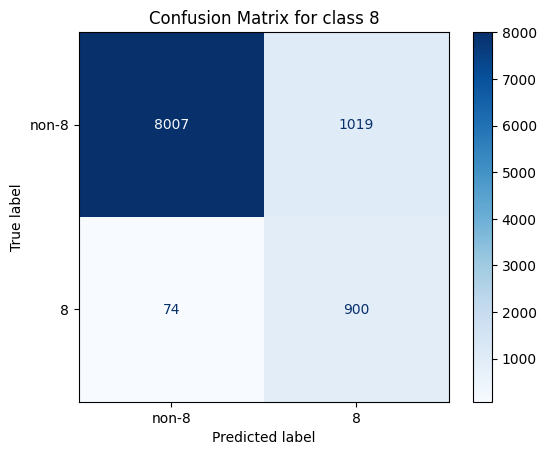

----------------------Training classifier for 9----------------------------
Training epoch: 1
Average loss: 0.471519, accuracy: 87.18%
Training epoch: 2
Average loss: 0.361722, accuracy: 90.83%
Training epoch: 3
Average loss: 0.342501, accuracy: 91.47%
Training epoch: 4
Average loss: 0.335122, accuracy: 91.75%
Training epoch: 5
Average loss: 0.328892, accuracy: 91.88%
Training epoch: 6
Average loss: 0.325942, accuracy: 92.10%
Training epoch: 7
Average loss: 0.323672, accuracy: 92.11%
Training epoch: 8
Average loss: 0.320836, accuracy: 92.31%
Training epoch: 9
Average loss: 0.319283, accuracy: 92.28%
Training epoch: 10
Average loss: 0.317934, accuracy: 92.45%
Testset accuracy: 93.2%, average loss: 0.349672


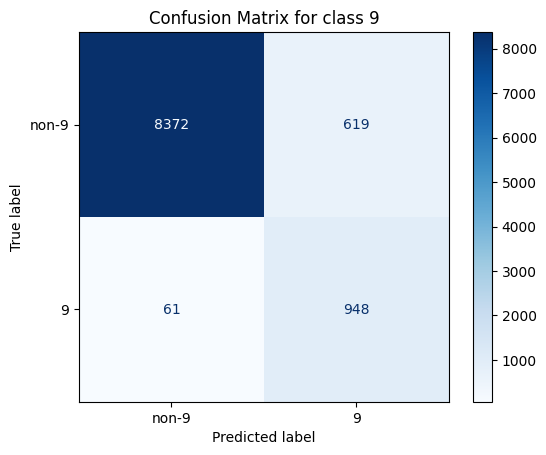

CPU times: user 12min 58s, sys: 5.58 s, total: 13min 4s
Wall time: 12min 51s


In [ ]:
%%time

epochs = 10
for i in range(1, 10):
  print(f"----------------------Training classifier for {i}----------------------------")
  for epoch in range(epochs):
      print(f"Training epoch: {epoch+1}")
      train(train_loader, models[i], criterions[i], optimizers[i], i)
  test(test_loader, models[i], criterions[i], i)
  plot_confusion_matrix(models[i], test_loader, i)

In [ ]:
for i in range(len(models)):
    torch.save(models[i].state_dict(), f'./models/model_{i}')

## verifica parametri del classificatore 0

In [ ]:
for param in models[0].parameters():
  print(param.size())

from torchsummary import summary
summary(models[0], input_size=(batch_size, 1, 28, 28))


torch.Size([1, 784])
torch.Size([1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]             785
Total params: 785
Trainable params: 785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


# **2. Load the Classifiers**

In [17]:
for i in range(len(models)):
    models[i].load_state_dict(torch.load(f'./models/model_{i}', weights_only=True))


Testset accuracy: 98.5%, average loss: 0.083303


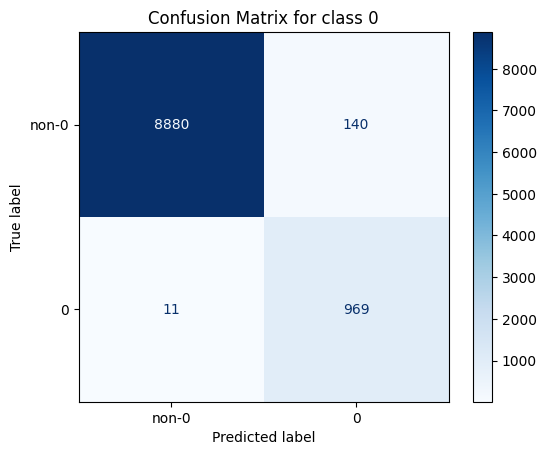


Testset accuracy: 98.5%, average loss: 0.076703


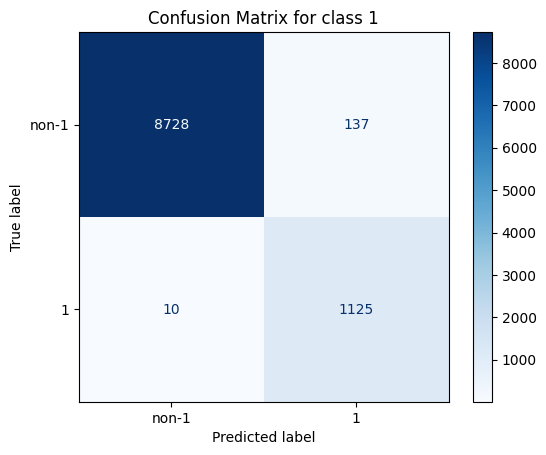


Testset accuracy: 97.5%, average loss: 0.315980


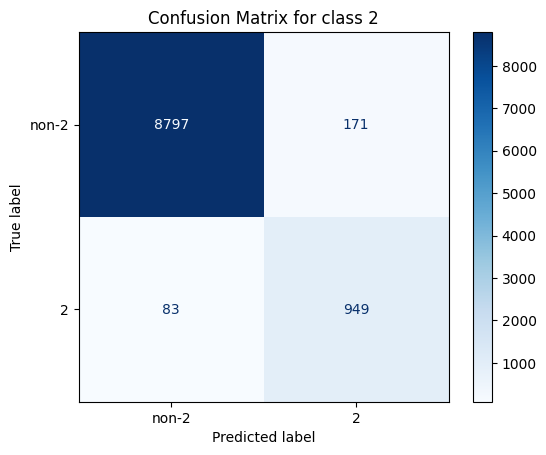


Testset accuracy: 94.6%, average loss: 0.275904


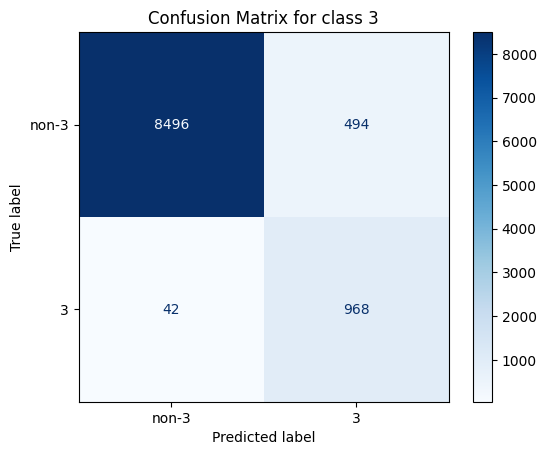


Testset accuracy: 96.6%, average loss: 0.159263


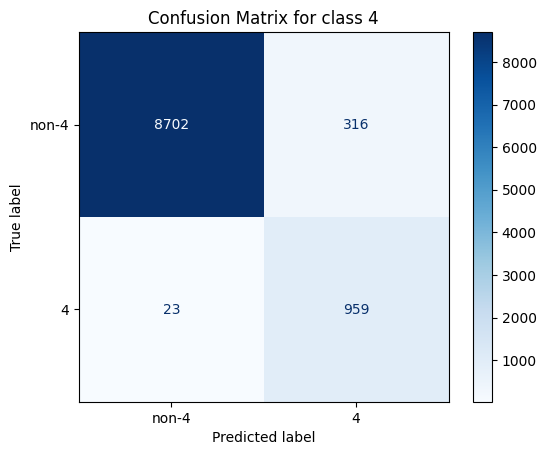


Testset accuracy: 92.8%, average loss: 0.320306


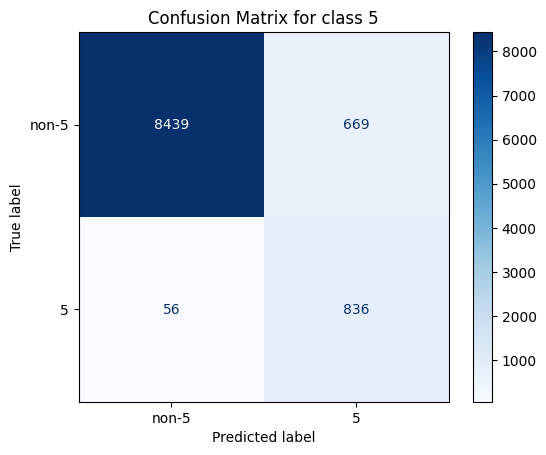


Testset accuracy: 97.8%, average loss: 0.127982


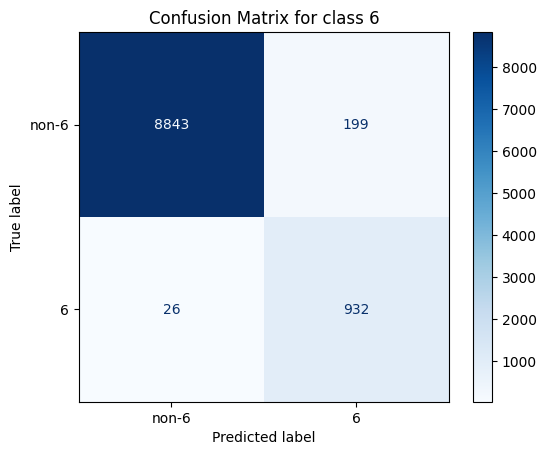


Testset accuracy: 97.2%, average loss: 0.213246


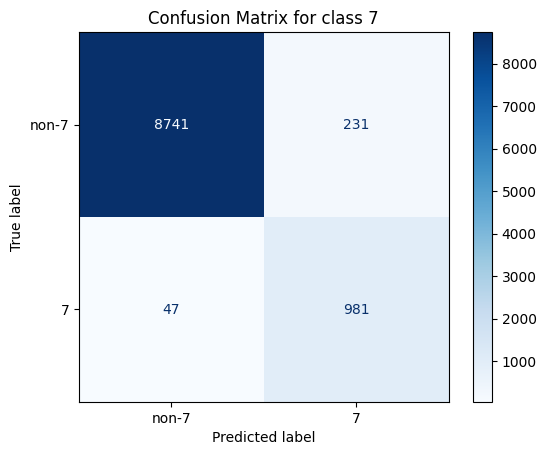


Testset accuracy: 89.1%, average loss: 0.422656


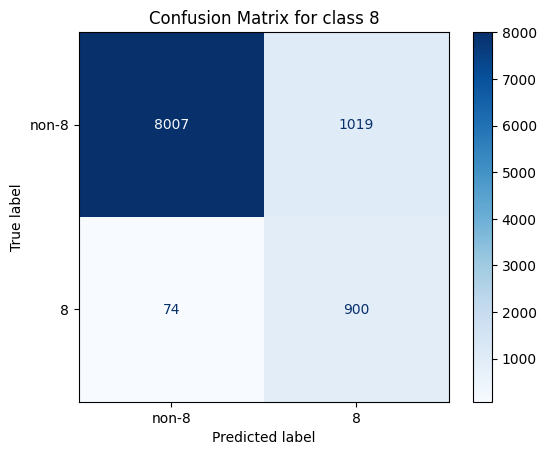


Testset accuracy: 93.2%, average loss: 0.349672


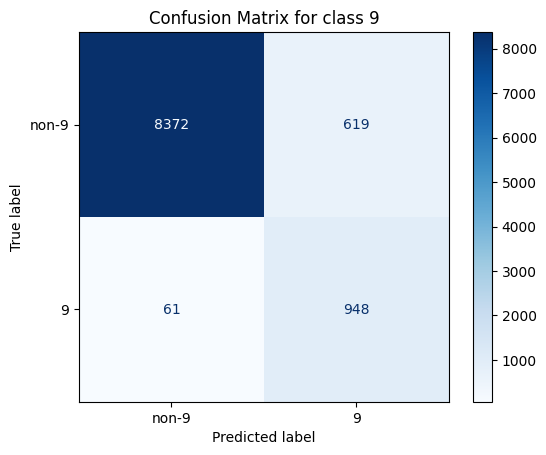

In [18]:
for i in range(len(models)):
    print("")
    test(test_loader, models[i], criterions[i], i)
    plot_confusion_matrix(models[i], test_loader, i)

# **3. Codifica Z3**

In [19]:
from z3 import *

In [20]:
def draw(witness, x_vars, title):
  witness_values = [witness[x_var].as_long() for x_var in x_vars]
  witness_tensor = torch.tensor(witness_values)
  witness_img = np.array(witness_tensor, dtype=np.uint8).reshape((28, 28))
  witness_img = np.array(witness_img).reshape((28, 28))
  plt.imshow(witness_img, cmap='gray', vmin=0, vmax=255)
  plt.axis('off')
  plt.title(f"{title}")
  plt.show()
  print(witness_values)

In [ ]:
def check(q):
  s = Solver()

  x_vars = [Int(f'x_{i}') for i in range(784)]# crea variabili (una per ogni pixel: 28*28=784)
  for x, i in zip(x_vars, range(len(x_vars))):
    s.add(x >= 0)
    s.add(x <= 255)
    #s.add(x != random.randint(0, 255))
  s.add(Sum([x_vars[i] for i in range(len(x_vars))]) > 20000)
  for model, i in zip(q, range(len(q))):
    W = list(model.parameters())[0].data
    b = list(model.parameters())[1].data
    W = torch.flatten(W)
    b = b.item()

    expr = Sum([RealVal(W[i].item()) * x_vars[i] for i in range(len(W))]) # combinazione lineare variabili e pesi in W
    #print(expr.sexpr())
    if i==1:
      s.add(expr + b >= 0) # formula finale (W*x + b >= 0)
    else:
      s.add(expr + b < 0) # formula finale (W*x + b >= 0)


  # verifico se è satisfiable, ovvero se esiste una soluzione al sistema di disequazioni
  res = s.check()
  print(res)
  if res == sat:
      witness = s.model()
      isValid(witness, q, x_vars)
  '''
  step = 50000
  for j in range(1):
    s.add(Sum([x_vars[i] for i in range(len(x_vars))]) >= step*(j+1))
    res = s.check()
    print(res)
    if res == sat:
      witness = s.model()
      witness_values = [witness[x_var].as_long() for x_var in x_vars]
      is0(witness_values)
    else:
      print("no solutions: ", unsat)
      break
  '''

# **3. Esempio esecuzione**

sat


/tmp/ipykernel_5389/3332769359.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = np.array(tens, dtype=np.uint8).reshape((28, 28))


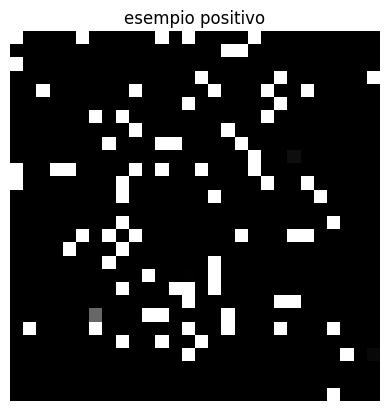

[255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 14, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255,

In [39]:
q0 = [models[0], models[1], models[2], models[3]]
check(q0)

------------ Esiste un 0 ? ---------------------
sat


/tmp/ipykernel_5389/3332769359.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = np.array(tens, dtype=np.uint8).reshape((28, 28))


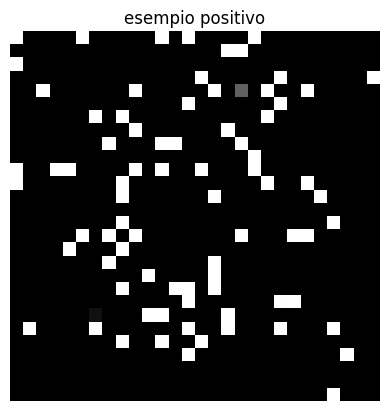

[255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 96, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255,

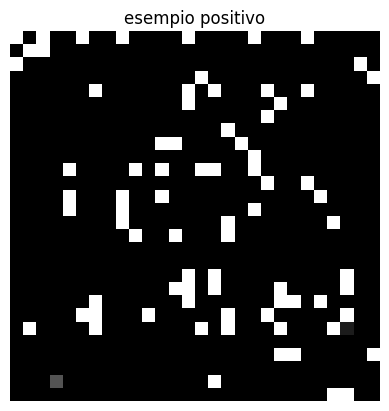

[255, 0, 255, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

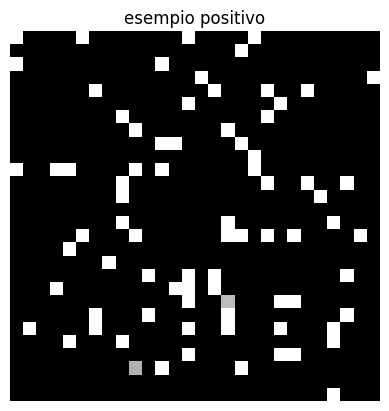

[255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

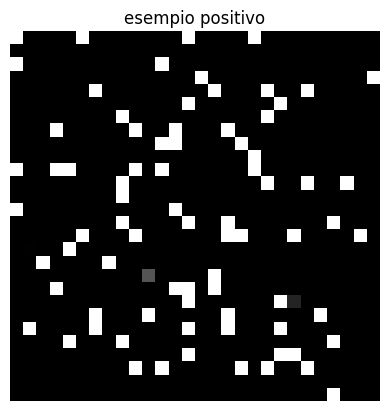

[255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

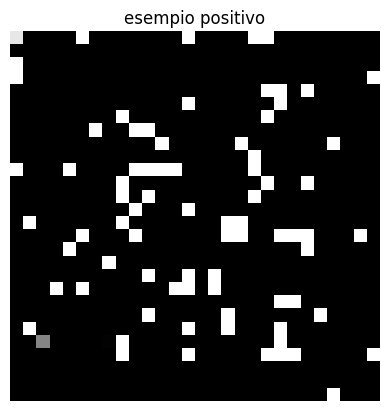

[231, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

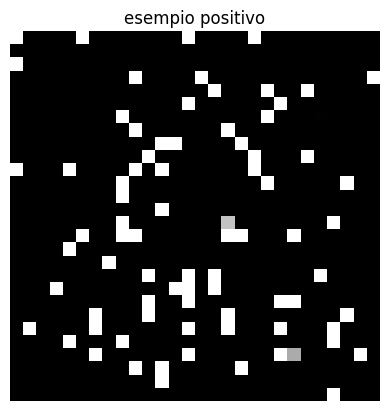

[255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

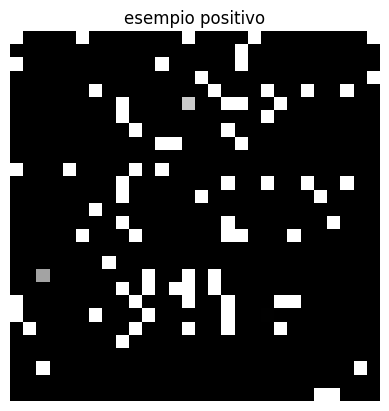

[255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 203, 0, 0, 255, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 254, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

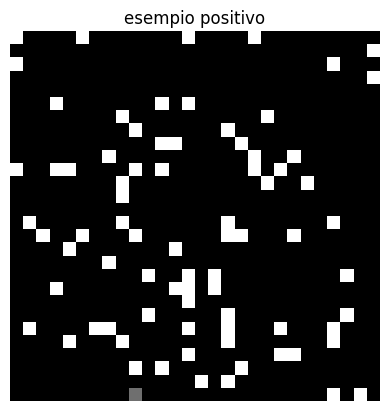

[255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

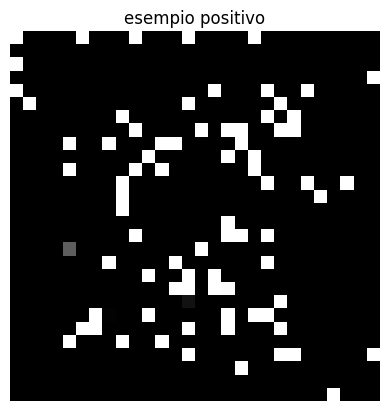

[255, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 255, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

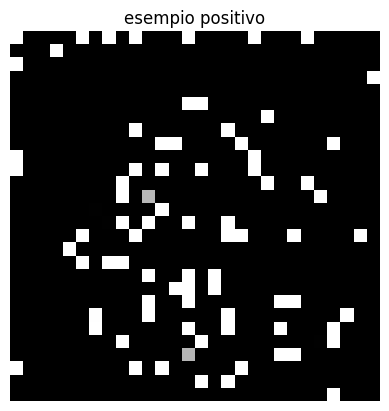

[255, 0, 0, 0, 0, 255, 0, 255, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
for model, i in zip(models, range(10)):
    print("------------ Esiste un", i, "? ---------------------")
    check([model])

sat


/tmp/ipykernel_5389/3332769359.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img = np.array(tens, dtype=np.uint8).reshape((28, 28))


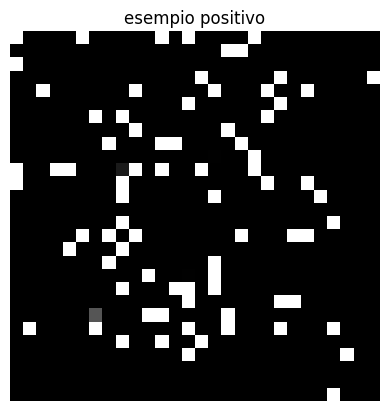

[255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 255, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 255, 255, 0, 0, 0, 26, 255, 0, 255, 0, 0, 255, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255,

In [46]:
q = [models[0], models[1], models[2], models[3], models[4], models[5]]
check(q)